In [1]:
import contextlib
import sys

import cv2
import k4a
import numpy as np
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms

from model.model_cnn import CNN_Classifier

In [2]:
def viz(device: k4a.Device):
    while True:
        capture = device.get_capture(-1)
        if capture.depth.data is not None:
            cv2.imshow('Depth', capture.depth.data)
        if capture.ir.data is not None:
            cv2.imshow('IR', capture.ir.data)
        if capture.color.data is not None:
            cv2.imshow('Color', capture.color.data)
        # if capture.transformed_depth is not None:
        #     cv2.imshow('Transformed Depth', capture.transformed_depth)
        # if capture.transformed_color is not None:
        #     cv2.imshow('Transformed Color', capture.transformed_color)
        # if capture.transformed_ir is not None:
        #     cv2.imshow('Transformed IR', capture.transformed_ir)

        key = cv2.waitKey(10)
        if key != -1:
            cv2.destroyAllWindows()
            break

In [3]:
# device.close()

In [4]:
device = k4a.Device.open()
if device is None:
    exit(-1)

device_config = k4a.DeviceConfiguration(
    color_format=k4a.EImageFormat.COLOR_BGRA32,
    color_resolution=k4a.EColorResolution.RES_720P,
    depth_mode=k4a.EDepthMode.NFOV_UNBINNED,
    camera_fps=k4a.EFramesPerSecond.FPS_5,
    synchronized_images_only=True,
    depth_delay_off_color_usec=0,
    wired_sync_mode=k4a.EWiredSyncMode.STANDALONE,
    subordinate_delay_off_master_usec=0,
    disable_streaming_indicator=False
)

# Start Cameras
status = device.start_cameras(device_config)
if status != k4a.EStatus.SUCCEEDED:
    exit(-1)

# Get Calibration
calibration = device.get_calibration(
    depth_mode=device_config.depth_mode,
    color_resolution=device_config.color_resolution,
)

# Create Transformation
transformation = k4a.Transformation(calibration)

In [2]:
GESTURES_SET = (
    # "high",
    "start",
    "select",
    # "swipe_right",
    # "swipe_left",
)

resized_image_size = (72, 128)
frames = 1
base_fps = 30
target_fps = 5
# target_fps = 30

label_map = {gesture: i for i, gesture in enumerate(GESTURES_SET, start=1)}
label_map["no_gesture"] = 0

batch_size = 8

CHECHPOINT_PATH = 'checkpoint01.pth'

In [3]:
torch_device = 'cpu' if not torch.cuda.is_available() else 'cuda'

model = CNN_Classifier(
    resized_image_size,
    frames=frames,
    batch_size=batch_size,
    num_classes=len(label_map.keys()),
)
model.to(torch_device)
model.load_state_dict(torch.load(CHECHPOINT_PATH, map_location=torch_device))
model.eval();

In [195]:
to_tensor = transforms.ToTensor()

resize = transforms.Resize(resized_image_size, transforms.InterpolationMode.NEAREST)

class NormalizeDepth():
    def __call__(self, tensor):
        mask = tensor > 0
        tensor_min = tensor[mask].min()
        tensor_max = tensor.max()
        res_tensor = torch.zeros_like(tensor)
        res_tensor[mask] = 1 - (tensor[mask] - tensor_min) / (tensor_max - tensor_min)
        return res_tensor

depth_norm = NormalizeDepth()

In [202]:
# Capture One Frame
capture = device.get_capture(-1)

depth_on_color = transformation.depth_image_to_color_camera(capture.depth)

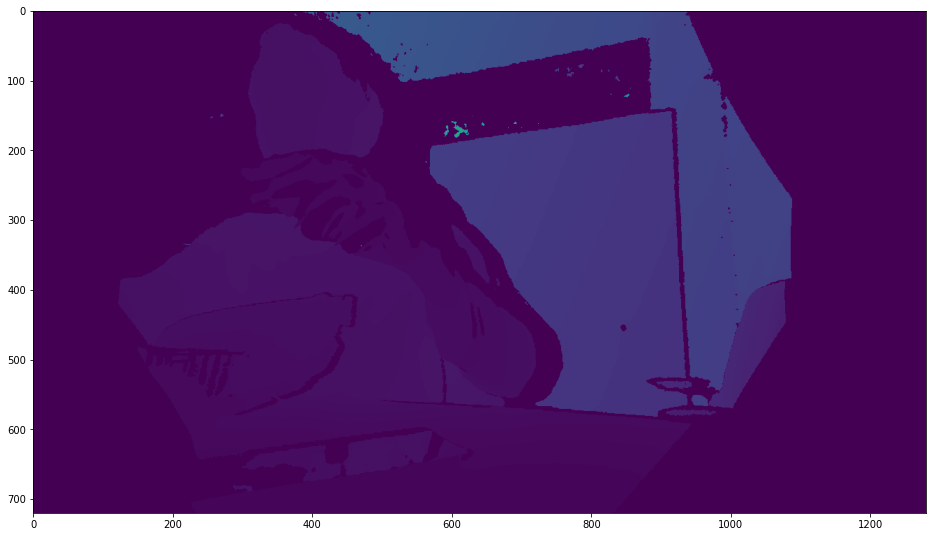

In [203]:
plt.figure(figsize=(16, 10))
plt.imshow(depth_on_color.data);

In [204]:
rgb = capture.color.data[:, :, :3][:, :, [2, 1, 0]]
depth = depth_on_color.data.astype(np.float32)
depth = np.where(depth > 2000, 0, depth)

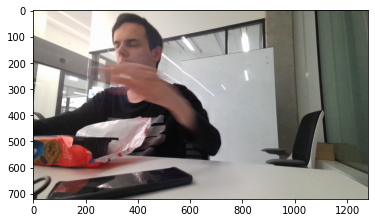

In [205]:
plt.imshow(rgb);

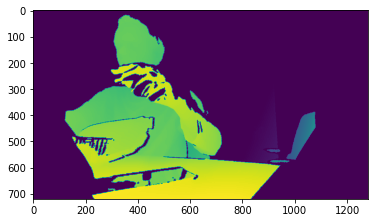

In [209]:
plt.imshow(depth_norm(to_tensor(depth))[0]);

In [207]:
input_image = resize(torch.cat((to_tensor(rgb), depth_norm(to_tensor(depth))), 0))

In [208]:
model(torch.cat([input_image[None, ...]] * batch_size))[0]

tensor([ 0.6164, -3.7517,  0.4745], grad_fn=<SelectBackward0>)

tensor([ 0.5857, -3.6622, -0.2692], grad_fn=<SelectBackward0>)


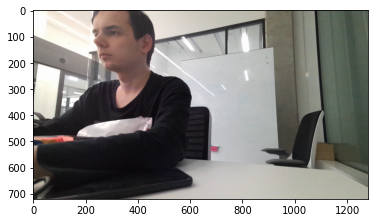

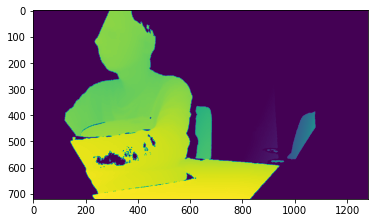

In [236]:
capture = device.get_capture(-1)
depth_on_color = transformation.depth_image_to_color_camera(capture.depth)

rgb = capture.color.data[:, :, :3][:, :, [2, 1, 0]]
depth = depth_on_color.data.astype(np.float32)
depth = np.where(depth > 2000, 0, depth)

input_image = resize(torch.cat((to_tensor(rgb), depth_norm(to_tensor(depth))), 0))[None, ...]
preds = model(torch.cat([input_image, torch.zeros((batch_size - 1, *input_image.shape[1:]))]))[0]

print(preds)
plt.imshow(rgb)
plt.show()
plt.imshow(depth_norm(to_tensor(depth))[0])
plt.show()

In [240]:
while True:
    capture = device.get_capture(-1)

    depth_on_color = transformation.depth_image_to_color_camera(capture.depth)

    rgb = capture.color.data[:, :, :3][:, :, [2, 1, 0]]
    depth = depth_on_color.data.astype(np.float32)
    depth = np.where(depth > 2000, 0, depth)

    input_image = resize(torch.cat((to_tensor(rgb), depth_norm(to_tensor(depth))), 0))[None, ...]
    preds = model(torch.cat([input_image, torch.zeros((batch_size - 1, *input_image.shape[1:]))]))[0]

    print(preds, capture.color.device_timestamp_usec)

    # if capture.depth.data is not None:
    #     cv2.imshow('Depth', capture.depth.data)
    # if capture.ir.data is not None:
        # cv2.imshow('IR', capture.ir.data)
    # if capture.color.data is not None:
    #     cv2.imshow('Color', capture.color.data)
    # if capture.transformed_depth is not None:
    #     cv2.imshow('Transformed Depth', capture.transformed_depth)
    # if capture.transformed_color is not None:
    #     cv2.imshow('Transformed Color', capture.transformed_color)
    # if capture.transformed_ir is not None:
    #     cv2.imshow('Transformed IR', capture.transformed_ir)

    key = cv2.waitKey(10)
    if key != -1:
        cv2.destroyAllWindows()
        break

tensor([ 0.6736, -3.8266,  0.2137], grad_fn=<SelectBackward0>) 3391596066
tensor([ 0.6714, -3.7754,  0.2287], grad_fn=<SelectBackward0>) 3391996133
tensor([ 0.6194, -3.6654,  0.1810], grad_fn=<SelectBackward0>) 3392196077
tensor([ 0.6587, -3.7658,  0.1878], grad_fn=<SelectBackward0>) 3392596077
tensor([ 0.6418, -3.7562,  0.1500], grad_fn=<SelectBackward0>) 3392796100
tensor([ 0.6717, -3.8399,  0.1355], grad_fn=<SelectBackward0>) 3393196100
tensor([ 0.6147, -3.7054,  0.3672], grad_fn=<SelectBackward0>) 3393396133
tensor([ 0.6873, -3.7276,  1.0378], grad_fn=<SelectBackward0>) 3393596077
tensor([ 0.6270, -3.3515,  0.8127], grad_fn=<SelectBackward0>) 3393796100
tensor([ 0.5999, -3.3068,  0.7739], grad_fn=<SelectBackward0>) 3393996066
tensor([ 0.6243, -3.1693,  0.6795], grad_fn=<SelectBackward0>) 3394196100
tensor([ 0.5797, -2.8759,  0.4709], grad_fn=<SelectBackward0>) 3394596077
tensor([ 0.6621, -2.9570,  0.6484], grad_fn=<SelectBackward0>) 3394796111
tensor([ 0.6141, -3.1056,  0.5532], gr

KeyboardInterrupt: 

In [35]:
# Capture One Frame
capture = device.get_capture(-1)

# Get Point Cloud
xyz_image = transformation.depth_image_to_point_cloud(capture.depth, k4a.ECalibrationType.DEPTH)
xyz = xyz_image.data[np.all(xyz_image.data[:, :] != np.zeros(3), axis=2)]
xyz = xyz[xyz[:, 2] < 2000]

In [85]:
step = 100

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=xyz[::step, 0],
            y=xyz[::step, 1],
            z=xyz[::step, 2],
            mode='markers',
            marker=dict(size=1)
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=True),
            yaxis=dict(visible=True),
            zaxis=dict(visible=True)
        )
    )
)
fig.show()

In [81]:
import time

frames = 10

ts_dev = [0] * frames
ts_sys = [0] * frames
ts_dt = [0] * frames

for i in range(frames):
    capture = device.get_capture(-1)

    ts_dev[i] = capture.color.device_timestamp_usec
    ts_sys[i] = capture.color.system_timestamp_nsec
    ts_dt[i] = time.time_ns()

In [82]:
an = ts_dev
# an = ts_sys
# an = ts_dt

for i in range(len(an) - 1):
    print(an[i + 1] - an[i])

200033
199945
200022
199978
200022
199978
200022
199967
200033
